## Data가 기존에 1.3GB => 400MB 까지 축소 가능

* [pandas handling](https://www.dataquest.io/blog/pandas-big-data/)

*  결측치 wildbird_antigen_dist 을 단순히 한 값을 넣는게 아니라 분포를 하나 더 넣어서 예를 들어 0 ~ 600 인 구간에서 결측치는 평균이 1000이고 scale을 3 을 줘서 하나의 봉우리를 만들고 600보다 크면, 결측치하는 방식으로 진행 중 

* 갑자기 학습이 안되는 ...?
* SWA 제거해보기

## [Batch Instance Normalization](https://blog.lunit.io/2018/05/25/batch-instance-normalization/)

In [1]:
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import pandas as pd
import pandas_profiling
import missingno as msno
import matplotlib.pyplot as plt
import pprint , seaborn as sns

In [2]:
data = pd.read_csv("./../IITP_GAN/wildbird_weather.csv", 
                   encoding='CP949' , low_memory=False)

In [3]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [4]:
mem_usage(data)

'1282.24 MB'

In [5]:
for dtype in ['float','int','object']:
    selected_dtype = data.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 19.48 MB
Average memory usage for int columns: 19.24 MB
Average memory usage for object columns: 110.98 MB


In [6]:
# We're going to be calculating memory usage a lot,
# so we'll create a function to save us some time!

data_int = data.select_dtypes(include=['int'])
converted_int = data_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(data_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([data_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

403.96 MB
138.86 MB


,before,after
uint8,NaN,15
int64,20.0,5


In [7]:
data_float = data.select_dtypes(include=['float'])
converted_float = data_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(data_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([data_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

545.35 MB
272.67 MB


,before,after
float32,NaN,27.0
float64,27.0,NaN


In [8]:
gl_obj = data.select_dtypes(include=['object']).copy()

converted_obj = pd.DataFrame()

for col in gl_obj.columns:
    num_unique_values = len(gl_obj[col].unique())
    num_total_values = len(gl_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = gl_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = gl_obj[col]
        
        
print(mem_usage(gl_obj))
print(mem_usage(converted_obj))

compare_obj = pd.concat([gl_obj.dtypes,converted_obj.dtypes],axis=1)
compare_obj.columns = ['before','after']
compare_obj.apply(pd.Series.value_counts)

332.93 MB
11.17 MB


,before,after
object,2.0,NaN
category,NaN,1.0
category,NaN,1.0


In [9]:
#optimized_gl = data.copy()

data[converted_int.columns] = converted_int
data[converted_float.columns] = converted_float
data[converted_obj.columns] = converted_obj

print("Change Memory size : {}".format(mem_usage(data)))

Change Memory size : 422.71 MB


```
msno.heatmap( data , figsize=(20,20))
plt.savefig("./IITP_EDA.png")
msno.dendrogram(data , figsize = (15,15))
plt.savefig("./IITP_EDA_Dandro.png")
msno.matrix(data)
plt.savefig("./IITP_MISSING_MATRIX.png")
plt.show()
```

In [10]:
frmhs_label = data.frmhs_no.values
dt_label = data.dt.values

"""
농장번호 숫자화하기.
"""

data.frmhs_no = data.frmhs_no.cat.codes

data.dt = data.dt.cat.codes


In [11]:
fac_var = []
num_var = []
for i in list(data) : 
    if data[i].nunique() < 20 : 
        #print("factor variable : {}, count : {} ".format(i, data[i].nunique()))
        fac_var.append(i)
    else : 
        #print("연속형 variable : {} , count : {} ".format(i, data[i].nunique()))
        num_var.append(i)

num_var.remove("dt")
num_var.remove("frmhs_no")
fac_var = fac_var + ["dt", "frmhs_no"]   
data = data.loc[:,fac_var + num_var]

col = list(data)


In [12]:
# for i , j in enumerate(col) :
#     print("{} , {}".format(i,j))

In [13]:
print("결측치 비율 : {}".format(2443628 / 2647409))

결측치 비율 : 0.923026249438602


In [14]:

import numpy as np

## 현재 결측치는 따로 버리지 않고 어떻게든 남기는 식으로 진행

```
nan_wild1_replace = {'wildbird_antigen_density_1km' : { 2.0 : np.nan }}
nan_wild2_replace = {'wildbird_antigen_density_2km' : { 3.0 : np.nan }}
nan_wild3_replace = {'wildbird_antigen_density_3km' : { 3.0 : np.nan }}
nan_wild4_replace = {'wildbird_antigen_density_4km' : { 3.0 : np.nan }}
nan_wild5_replace = {'wildbird_antigen_density_5km' : { 4.0 : np.nan }}
nan_wild_dist_replace = {'wildbird_antigen_dist' : } ## 600 보다 크면 nan 으로 
```

In [15]:
wild1_replace = {'wildbird_antigen_density_1km' : { np.nan : 2.0 }}
wild2_replace = {'wildbird_antigen_density_2km' : { np.nan : 3.0 }}
wild3_replace = {'wildbird_antigen_density_3km' : { np.nan : 3.0 }}
wild4_replace = {'wildbird_antigen_density_4km' : { np.nan : 3.0 }}
wild5_replace = {'wildbird_antigen_density_5km' : { np.nan : 4.0 }}
#wild_dist_replace = {'wildbird_antigen_dist' : { np.nan : nan_dist }} ## 600 보다 크면 nan 으로 

In [16]:
data.replace(wild1_replace , inplace=True ,)
data.replace(wild2_replace , inplace=True )
data.replace(wild3_replace ,inplace=True  )
data.replace(wild4_replace ,inplace=True )
data.replace(wild5_replace ,inplace=True )
#data.replace(wild_dist_replace , inplace=True )

## 600 이상인 것에 봉우리를 하나 만들어서 해결해보기

In [17]:
count = data.wildbird_antigen_dist.isnull().sum()
nan_dist = np.random.normal(loc= 1000 , scale= 3 , size=[count])

dist_index = data.wildbird_antigen_dist.isnull().values
data.loc[dist_index , "wildbird_antigen_dist"] = nan_dist

#data["wildbird_antigen_dist"]

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


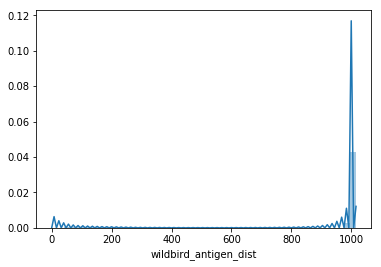

In [18]:
sns.distplot(data.wildbird_antigen_dist)

In [19]:
# row , ncol = 7, 8

# fig , axes = plt.subplots(row , ncol , figsize = (26,13))
# fig.subplots_adjust(hspace = 0.35 , wspace= 0.14 , top = 0.92 , left = 0.03 , bottom = 0.04 , right = 0.99)


# col2 = 0
# for j in range(row) :
#     for k in range(ncol) :
#         try :
#             label = col[col2]
#             real_0 = data_sample.loc[: , label]
#             real_0.name ="Real"
#             col2 += 1
#             if label in fac_var : 
#                 sns.distplot(real_0 , ax=axes[j , k],norm_hist =True, kde=False , hist_kws ={"color":"g" , "label" :"Real", "rwidth":0.75})
#                 axes[j , k].legend(fontsize = 10)
#             elif label in num_var : 
#                 sns.distplot(  real_0 , ax=axes[j , k] ,
#                              kde_kws={"color": "g", "lw": 2, "label": "Real", "shade" : True } , hist =False , rug = False) # 
#                 axes[j , k].legend(fontsize = 10 )
#             axes[j , k].set_title( label , loc ="left" , fontsize= 10 )
#             axes[j , k].set_xlabel(' ')
#         except IndexError as e : 
#             axes[j , k].axis("off")
# plt.savefig("./IITP_EDA/visualization_Data.png")
# plt.show()


In [20]:

import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from scipy.stats import skew
from scipy.stats import kurtosis

from pprint import pprint

from moving_free_batch_normalization import moving_free_batch_norm
from stochastic_weight_averaging import StochasticWeightAveraging

import os
import tensorflow as tf

slim = tf.contrib.slim

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [21]:
mb_size = 3000
X_dim = np.shape(data)[1]
z_dim = 50
lr = 0.0001
beta_1 = 0.5
beta_2 = 0.9
d_steps = 5
g_steps = 3
EPOCHS = 50000
Margin = 9
Margin_LIMIT = Margin - 1 
ROW , COL = 7,7
data_len = np.shape(data)[0]
batch_iter = int(data_len / mb_size)
LAMDA = 10 
Recon_weight = 2

seed_n = np.random.randint(1, 1000, size=1 )[0]

tf.random.set_random_seed(seed_n)


remark = "kl loss + LP 로 해보기 , Batch Instance Norm 해보기"
title = "0316_IITP_Batch_Instance_Norm"

path_v = title

loss_func = "ragan_gp"

model_dir = "./Model_Save/{}".format(path_v)
vis_dir =  model_dir + "/vis"

if not os.path.exists(model_dir) :
    os.makedirs(model_dir)
    os.makedirs(vis_dir)

if loss_func == "ragan_gp" :
    Gradient_type = ["GP","LP"][np.random.randint(0, 2, size=1 )[0]]
else :
    Gradient_type = "None" 
    
DATA_RANGE = (-1,1)


select1 = np.random.randint(0, 2, size=1 )[0]
select2 = np.random.randint(0, 2, size=1 )[0]

relu_w_init = [tf.keras.initializers.he_uniform(seed = seed_n) ,
               tf.keras.initializers.he_normal(seed = seed_n)][select1]
tanh_w_init = [tf.keras.initializers.glorot_normal(seed = seed_n) ,
               tf.keras.initializers.glorot_uniform(seed = seed_n)][select2]



relu_w_say = ["he uniform" , "he normal"][select1]


if DATA_RANGE == (0,1) :
    g_act = tf.nn.sigmoid
    tanh_w_say = "None"
if DATA_RANGE == (-1,1) :
    g_act = tf.nn.tanh
    tanh_w_say = ["glorot normal" , "glorot uniform"][select2]


spec_iter = np.random.randint(1,4, size = 1)[0]

D_layer_count = np.random.randint(4, 6, size=1 )[0]
G_layer_count = np.random.randint(4, 6, size=1 )[0]
G_layer = list(np.sort(np.random.randint(50, 60, size=G_layer_count ))[::-1])
D_layer = list(np.sort(np.random.randint(12, 65, size=D_layer_count ))[::-1])
    
G_H = [z_dim ] + G_layer + [ X_dim ]
D_H = [X_dim ] + D_layer + [ 1 ]

tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, X_dim], name="X")
Z = tf.placeholder(tf.float32, shape=[None, z_dim], name="z")
batch_size = tf.placeholder(tf.int64)
dataset = tf.data.Dataset.from_tensor_slices((X, Z)).batch(batch_size ,drop_remainder= True ).repeat().shuffle(1000)


#is_training_bn = tf.placeholder(shape=[], dtype=tf.bool)
#use_moving_statistics = tf.placeholder(shape=[], dtype=tf.bool)
learning_rate = tf.placeholder(shape=[], dtype=tf.float32)


iter = dataset.make_initializable_iterator()
x , z = iter.get_next()
print("="*30)
print("Title : {}".format(title))
print("Loss func : {}".format(loss_func))
print("Model Directory : {}".format(model_dir))
print("Gradient Type : {} , Lambda : {}".format(Gradient_type , LAMDA ))
print("Data RANGE : {} , G activation : {}".format(DATA_RANGE , g_act))
print("G Hidden : {}".format(G_H))
print("D Hidden : {}".format(D_H))
print("Dim : {} , Z dim : {}, Margin : {}".format(np.shape(data) , z_dim , Margin))
print("Epoch : {} , Batch SIZE : {} , Batch Iter : {}".format(EPOCHS , mb_size , batch_iter))
print(" Beta1 : {} , Beta2 : {}".format( beta_1 , beta_2))
print("D Step : {} , G Step : {}".format(d_steps , g_steps))
print("="*30)


inner = [[remark , title , loss_func , model_dir , Gradient_type , LAMDA , spec_iter , 
          Recon_weight , seed_n , DATA_RANGE , g_act , G_H  , D_H , relu_w_say , tanh_w_say , 
 np.shape(data) , z_dim , Margin , EPOCHS , mb_size , batch_iter , beta_1 , beta_2, d_steps , g_steps]]

colname = ["Remark : " ,  "Title : " , "Loss function : " , "Model 경로 : " , "Gradient 타입 : " , "LAMDA : " ,  "spec iter" , 
           "Reconstrunction weight : " ,  "seed" ,
           'G 생성 범위 : ' , 'G 생성 함수 : ' ,"G Hidden SIZE : " , "D Hidden SIZE : " , 
           "Relu W init" , "Tanh W init" , 
           "Data Shape : " , " Z dim : " ,
           "Margin : ", "Epochs : " , "Batch size  : " , 
           " Batch Iteration : " , "Beta 1 : " , "Beta 2 : " ,
           "D steps : " , "G steps  : " ]

pd.DataFrame( inner , columns = colname).T.to_csv(model_dir + "/summary.csv")

Title : 0316_IITP_Batch_Instance_Norm
Loss func : ragan_gp
Model Directory : ./Model_Save/0316_IITP_Batch_Instance_Norm
Gradient Type : LP , Lambda : 10
Data RANGE : (-1, 1) , G activation : <function tanh at 0x7f3f757187b8>
G Hidden : [50, 56, 56, 55, 53, 49]
D Hidden : [49, 64, 43, 35, 27, 19, 1]
Dim : (2647409, 49) , Z dim : 50, Margin : 9
Epoch : 50000 , Batch SIZE : 3000 , Batch Iter : 882
 Beta1 : 0.5 , Beta2 : 0.9
D Step : 5 , G Step : 3


In [22]:
def batch_instance_norm(x, scope='batch_instance_norm'):
    with tf.variable_scope(scope):
        ch = x.shape[-1]
        eps = 1e-5

        batch_mean, batch_sigma = tf.nn.moments(x, axes=[0, 1], keep_dims=True)
        x_batch = (x - batch_mean) / (tf.sqrt(batch_sigma + eps))

        ins_mean, ins_sigma = tf.nn.moments(x, axes=[1], keep_dims=True)
        x_ins = (x - ins_mean) / (tf.sqrt(ins_sigma + eps))

        rho = tf.get_variable("rho", [ch], initializer=tf.constant_initializer(1.0), constraint=lambda x: tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0))
        gamma = tf.get_variable("gamma", [ch], initializer=tf.constant_initializer(1.0))
        beta = tf.get_variable("beta", [ch], initializer=tf.constant_initializer(0.0))

        x_hat = rho * x_batch + (1 - rho) * x_ins
        x_hat = x_hat * gamma + beta

        return x_hat


def layer(prev = None , shape1 = None , shape2 = None , 
          name = None , activation = tf.nn.leaky_relu ,
          final = False , SN = True , BN = False , Type = None) :
    
    if activation == tf.nn.leaky_relu or activation == tf.nn.relu : 
        init = relu_w_init
    
    elif activation == tf.nn.tanh :
        init = tanh_w_init
    
    W1 = tf.get_variable("Weight" + str(name) , shape = [shape1 , shape2] , dtype = tf.float32 ,
                        initializer = init)
    b1 = tf.get_variable("Bias" + str(name) , shape = [shape2] , dtype = tf.float32 ,
                        initializer = tf.constant_initializer(0.001))
    W2 = spectral_norm(W1 , name = "SN" + str(name))
    if final == True :
        layer = tf.matmul( prev , W1 )
    else :
        if SN == True :
            layer = tf.matmul( prev , W2) + b1
            layer = activation(layer)
        else : 
            layer = tf.matmul( prev , W1) + b1
            if Type == "SWA" :
                layer = moving_free_batch_norm(layer, axis=-1, training=is_training_bn,
                                               use_moving_statistics=use_moving_statistics, momentum=0.99)
                layer = activation(layer)
            elif Type == "Self_Normal" :
                layer = activation(layer)
                layer = tf.contrib.nn.alpha_dropout(layer , 0.5)
            elif Type == "INSTANCE_NORM" :
                ## Instance norm
                layer = tf.contrib.layers.instance_norm(layer)
                layer = activation(layer)
            elif Type == "Layer_Norm" :
                ## Instance norm
                layer = tf.contrib.layers.layer_norm(layer)
                layer = activation(layer)
            elif Type == "Batch_Instance_Norm" : 
                layer = batch_instance_norm(layer, scope="Batch_Instance_" + name )
                layer = activation(layer)
                
    return layer



def G(Z = None , reuse = tf.AUTO_REUSE) :
    with tf.variable_scope("Generator" , reuse = reuse) as scope: 
        h = layer(prev = Z , shape1 = G_H[0], shape2 = G_H[1] ,
                  name = "G_first", SN = False , BN = True , Type = "Batch_Instance_Norm")
        for i in range( len(G_H) ) :
            if (i + 2) >= (len(G_H) -1 ) :
                continue
            else :
                h = layer(prev= h , shape1 = G_H[i+1], shape2 = G_H[i+2] ,
                          name = "G" + str(i) , SN = False, BN = True, Type = "Batch_Instance_Norm")
        Out = layer(prev = h , shape1 = G_H[-2] , shape2 = G_H[-1] ,
                   name = "W_G_final", final = True)
        
        if g_act == tf.nn.sigmoid :
            G_final_b = tf.get_variable("Bias_final" , shape = [G_H[-1]],
                                       dtype = tf.float32 , initializer = tf.constant_initializer(0.001))
            Out = g_act( Out + G_final_b)
        else :
            Out = g_act( Out )
        return Out
    

def D(X = None , reuse = tf.AUTO_REUSE) :
    with tf.variable_scope("Discriminator" , reuse = reuse) as scope: 
        h = layer( prev = X , shape1 = D_H[0], shape2 = D_H[1] ,
                  name = "D_first", SN = True )
        for i in range( len(D_H) ) :
            if (i + 2) >= (len(D_H) -1 ) :
                continue
            else :
                h = layer(prev= h , shape1 = D_H[i+1], shape2 = D_H[i+2] ,
                          name = "D" + str(i) , SN = True )
        Out = layer(prev = h , shape1 = D_H[-2] , shape2 = D_H[-1] ,
                   name = "W_D_final", final = True)
        
        return Out
    
def sample_z(m, n) :
    return np.random.uniform(-1., 1., size=[m, n])

def log(x):
    return tf.log( tf.maximum( x , 1e-8) )



def spectral_norm(w, iteration= spec_iter , name = None):
    w_shape = w.shape.as_list()
    w = tf.reshape(w, [-1, w_shape[-1]])
    
    u = tf.get_variable(name , [1, w_shape[-1]], initializer=tf.random_normal_initializer(), trainable=False)

    u_hat = u
    v_hat = None
    for i in range(iteration):
       
        """
       power iteration
       Usually iteration = 1 will be enough
       """
        
        v_ = tf.matmul(u_hat, tf.transpose(w))
        v_hat = tf.nn.l2_normalize(v_)

        u_ = tf.matmul(v_hat, w)
        u_hat = tf.nn.l2_normalize(u_)

    u_hat = tf.stop_gradient(u_hat)
    v_hat = tf.stop_gradient(v_hat)

    sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))

    with tf.control_dependencies([u.assign(u_hat)]):
        w_norm = w / sigma
        w_norm = tf.reshape(w_norm, w_shape)

    return w_norm 


def Discriminator_loss( Ra = None, loss_func = None, real = None, fake = None) :
    loss = 0
    if Ra :
        fake_logit = (fake - tf.reduce_mean(real))
        real_logit = (real - tf.reduce_mean(fake))
        
        if loss_func == "ralsgan" :
            fake_loss = tf.reduce_mean( tf.square( fake_logit + 1 ))
            real_loss = tf.reduce_mean( tf.square( real_logit - 1 ))
            loss = real_loss + fake_loss
        if loss_func == "ragan_gp" or loss_func == "ragan" :
            real_logit = tf.sigmoid( real_logit )
            fake_logit = tf.sigmoid( fake_logit )
            loss = - tf.reduce_mean( log(real_logit)) - tf.reduce_mean( log(1-fake_logit ))
        if loss_func == "rahinge" :
            fake_loss = tf.reduce_mean( tf.nn.relu( 1 + fake_logit ))
            real_loss = tf.reduce_mean( tf.nn.relu( 1 - real_logit ))
            loss = real_loss + fake_loss
    
    return loss

def Generator_loss(Ra  = None , loss_func  = None , real = None ,fake = None ) :
    loss = 0
    if Ra :
        fake_logit = (fake - tf.reduce_mean(real))
        real_logit = (real - tf.reduce_mean(fake))
        
        if loss_func == "ralsgan" :
            fake_loss = tf.reduce_mean( tf.square( fake_logit - 1 ))
            real_loss = tf.reduce_mean( tf.square( real_logit + 1 ))
            loss = real_loss + fake_loss
        if loss_func == "ragan_gp" or loss_func == "ragan" :
            real_logit = tf.sigmoid( real_logit )
            fake_logit = tf.sigmoid( fake_logit )
            loss = - tf.reduce_mean( log( fake_logit )) - tf.reduce_mean( log(1- real_logit ))
        if loss_func == "rahinge" :
            fake_loss = tf.reduce_mean( tf.nn.relu( 1 - fake_logit ))
            real_loss = tf.reduce_mean( tf.nn.relu( 1 + real_logit ))
            loss = real_loss + fake_loss
    
    return loss



In [23]:
G_sample = G(z)

D_real = D(x )
D_fake = D(G_sample )

In [24]:

e = tf.random_uniform([batch_size , 1] , 0 , 1)
x_hat = e * x + (1-e) * G_sample
grad  = tf.gradients( D(x_hat), x_hat)[0]
grad_norm = tf.norm( tf.layers.flatten(grad) , axis = 1)

if Gradient_type == "GP" :
    GP = LAMDA * tf.reduce_mean( tf.square( grad_norm - 1.0))
elif Gradient_type == "LP" :    
    GP = LAMDA * tf.reduce_mean( tf.square( tf.maximum(0.0 ,grad_norm - 1.0)))
else :
    GP = 0

print(GP)

Tensor("mul_2:0", shape=(), dtype=float32)


In [25]:

D_loss = Discriminator_loss(True , loss_func , D_real , D_fake) + GP
G_loss = Generator_loss(True , loss_func , D_real , D_fake)


gene_17 = tf.contrib.framework.sort(tf.transpose(tf.nn.embedding_lookup(tf.transpose(G_sample), 17)))
true_17 = tf.contrib.framework.sort(tf.transpose(tf.nn.embedding_lookup(tf.transpose(x), 17)))


In [26]:
gene_17 = gene_17 / tf.reduce_sum(gene_17)
true_17 = true_17 / tf.reduce_sum(true_17)

In [27]:

gene_17 = tf.add(gene_17 , 1.1 ) # 0 ~ 2 범위로 만들어서 음수랑 0 나오지 않게 방지하기 
true_17 = tf.add(true_17 , 1.1 ) # 0 ~ 2 범위로 만들어서 음수랑 0 나오지 않게 방지하기 
gene_17 = tf.divide( gene_17 , tf.reduce_sum(gene_17))
true_17 = tf.divide(true_17 , tf.reduce_sum(true_17))

def kl_divergence(p, q): 
    return tf.reduce_sum(p * log( p/q  ))


recon_loss_17 = tf.nn.relu( kl_divergence(true_17 , gene_17 ) )
#recon_loss_17 = tf.reduce_mean( tf.square(tf.subtract(true_17 , gene_17)))
recon_loss = Recon_weight * recon_loss_17



In [28]:
t_vars = tf.trainable_variables()

d_vars = [var for var in t_vars if 'Discriminator' in var.name]
g_vars = [var for var in t_vars if 'Generator' in var.name]
recon_vars = g_vars

#pp.pprint(g_vars)
#print("\n")
#pp.pprint(d_vars)

In [29]:
#update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#update_bn_ops = tf.get_collection('UPDATE_BN_OPS')
#reset_bn_ops = tf.get_collection('RESET_BN_OPS')
#update_ops = tf.group(*update_ops)
#update_bn_ops = tf.group(*update_bn_ops)
#reset_bn_ops = tf.group(*reset_bn_ops)



In [30]:
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=beta_1 , beta2 = beta_2).minimize(G_loss, var_list=g_vars)
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta_1 , beta2 = beta_2).minimize(D_loss, var_list=d_vars)
    Recon_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta_1 , beta2 = beta_2).minimize(recon_loss, var_list=recon_vars)
    


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [31]:
# with tf.name_scope('SWA'):
#     swa = StochasticWeightAveraging()
#     swa_op = swa.apply(var_list=g_vars)
#     # Make backup variables
#     with tf.variable_scope('BackupVariables'):
#         backup_vars = [tf.get_variable(var.op.name, dtype=var.value().dtype, trainable=False,
#                                        initializer=var.initialized_value())
#                        for var in g_vars ]
#     # operation to assign SWA weights to model
#     swa_to_weights = tf.group(*(tf.assign(var, swa.average(var).read_value()) for var in g_vars))
#     # operation to store model into backup variables
#     save_weight_backups = tf.group(*(tf.assign(bck, var.read_value()) for var, bck in zip(g_vars, backup_vars)))
#     # operation to get back values from backup variables to model
#     restore_weight_backups = tf.group(*(tf.assign(var, bck.read_value()) for var, bck in zip(g_vars, backup_vars)))

In [32]:
from sklearn.preprocessing import MinMaxScaler

def sample_data(data = None , n= len(data)) : 
    output = data[list(np.random.choice(len(data) , n))]
    
    return output

scaler = MinMaxScaler(feature_range= DATA_RANGE )

x_plot = pd.DataFrame(sample_data(data = data.values , n=mb_size) , columns = col)
data = scaler.fit_transform(data)

/home/gpuadmin/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int16, float32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [39]:
def Check_KS(ks_output , Total_ks_graph , Margin , ROW , COL ) : 
    clear_output(wait= True)
    print("KS Plot")
    total = sess.run(G_sample , feed_dict=feed_dict_train)
    total = scaler.inverse_transform(total)
    g_plot = pd.DataFrame(total , columns = col )
    g_plot[fac_var] = g_plot[fac_var].round(0)
    Value = []
    for label in col :
        sample = g_plot[label]
        real   = x_plot[label]
        ks , p = stats.ks_2samp(real.values , sample.values)
        Value.append(ks)
    Total_KS = round( np.sum(Value) , 2)
    ks_2 = [iteration] + Value
    ks_3 = pd.DataFrame([ks_2], columns = ["iter"] + col)
    ks_output = ks_output.append(ks_3)
    fig , ax = plt.subplots(figsize=(26,13))
    fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.05 , right = 0.99)
    updown = 0
    for name in col : 
        if updown % 2 == 0 :
            param , space="bottom" , "  "
        else : 
            param , space ="top" , "   "
        ax.plot(ks_output.iter , ks_output[[name]], label = name)
        ax.text(iteration , ks_output.loc[ks_output["iter"]==iteration , [name]].values , space + name ,
                verticalalignment = param)
        updown +=1
    ax.set_title("KS [{}]".format(Total_KS) , fontsize = 30 )
    ax.set_xlabel("Epoch")
    ax.set_ylabel("KS")    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=15 , fontsize= 10)
    ax.text(iteration+1 , 0.05 , "   0.05", verticalalignment = param)
    ax.axhline(0.05, linewidth=4, color='r')
    ax.set_title("[{}] , EPOCH : {} , KS : {}[{}][{}]".format(title , iteration-1 , Total_KS , Total_ks_graph.ks.min() ,len(col) ) , fontsize = 30)
    plt.savefig(model_dir +"/IND_KS_Log_{}.png".format(path_v))
    plt.show()
    """
    Total Graph
    """
    
    print("Total KS Plot")
    Total_ks_graph_ap = pd.DataFrame({"iter":[iteration] , "ks" :[Total_KS]})
    Total_ks_graph    = Total_ks_graph.append(Total_ks_graph_ap)
    #Total_ks_graph    = Total_ks_graph[Total_ks_graph.iter>0]
    fig , ax = plt.subplots(figsize = (26,13))
    fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)
    ax.plot(Total_ks_graph.iter , Total_ks_graph.ks , linestyle ="-" , marker ="." , linewidth = 3, markersize = 12)
    ax.axhline(0.05, linewidth=4, color='r')
    ax.set_title("[{}] , EPOCH : {} , KS : {}[{}][{}]".format(title , iteration-1 , Total_KS , Total_ks_graph.ks.min() ,len(col) ) , fontsize = 30)
    plt.savefig(model_dir +"/Total_KS_Log{}.png".format(path_v))
    plt.show()
    
    fig , ax = plt.subplots(figsize = (26,13))
    fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)

    ax.plot(output.iter , output.dloss , label ="dloss" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
    ax.plot(output.iter , output.gloss , label ="gloss" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
    ax.set_title("[{}] , EPOCH : {} , Dloss : {} , Gloss : {} , KS : {}".format(title , iteration-1 ,  dloss, gloss , Total_KS), fontsize= 30)
    ax.set_ylim(-5, 15)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4 , fontsize= 20)
    plt.savefig(model_dir +"/LOSS_Log_{}.png".format(path_v))
    plt.show()
    
    if Margin > Total_KS : 
        show_plot(row = ROW , ncol= COL )
        print("=======UPDate============")
        with open(model_dir + "/Change_Margin.txt", "a") as f:
            f.write("Epoch : {} , Margin : {} ===> {} \n".format(iteration , Margin , Total_KS))
        Margin = Total_KS
        ## 여기선 특정 샘플 저장해야 하므로. 원하는 개수 만큼.
        generate = {}
        generate[z] = sample_z(50000, z_dim)
        total = sess.run(G_sample, feed_dict= generate )
        total = scaler.inverse_transform(total)
        g_plot = pd.DataFrame(total , columns = col )
        g_plot[fac_var] = g_plot[fac_var].round(0)
        g_plot.to_csv(model_dir + "/Generated_{}.csv".format(path_v) , index = False)
        
        saver.save(sess , model_dir + "/MODEL_{}".format(path_v))
    return ks_output , Total_ks_graph , Margin , Total_KS

In [40]:
from scipy import stats
def show_plot(row , ncol ) : 
    
    fig , axes = plt.subplots(row , ncol , figsize = (26,13))
    fig.subplots_adjust(hspace = 0.35 , wspace= 0.14 , top = 0.92 , left = 0.03 , bottom = 0.04 , right = 0.99)
    total = sess.run( G_sample , feed_dict=feed_dict_train )
    try : 
        total = total[~np.isnan(total).any(axis=1)]
        total = scaler.inverse_transform(total)
        g_plot = pd.DataFrame(total , columns = col )
        g_plot[fac_var] = g_plot[fac_var].round(0)
        """
        좀 더 쉬운 분포로 만들어서 학습시킨 후 다시 원래값으로 (factor 변수이기 때문에 가능하다 생각함.)
        """

        col2 = 0
        error = []
        for j in range(row) :
            for k in range(ncol) :
                try :
                    label = col[col2]
                    sample = g_plot.loc[: , label]
                    sample.name = "Gene"
                    real_0 = x_plot.loc[: , label]
                    real_0.name ="Real"
                    ks , p = stats.ks_2samp(real_0.values , sample.values)
                    error.append(ks)
                    col2 += 1
                    if label in fac_var : 
                        sns.distplot( sample , ax=axes[j , k], norm_hist =True , kde=False , hist_kws ={"color":"r" , "label" :"Gene", "rwidth":0.75})
                        sns.distplot(real_0 , ax=axes[j , k],norm_hist =True, kde=False , hist_kws ={"color":"g" , "label" :"Real", "rwidth":0.75})
                        axes[j , k].legend(fontsize = 10)
                    elif label in num_var : 
                        sns.distplot(  sample , ax=axes[j , k] ,
                                     kde_kws={"color": "r", "lw": 2, "label": "Gene" , "shade" : True} , hist =False , rug = False) #   
                        sns.distplot(  real_0 , ax=axes[j , k] ,
                                     kde_kws={"color": "g", "lw": 2, "label": "Real", "shade" : True } , hist =False , rug = False) # 
                        axes[j , k].legend(fontsize = 10 )
                    axes[j , k].set_title( label , loc ="center" , fontsize= 10 )
                    axes[j , k].set_xlabel(' ')
                except IndexError as e : 
                    axes[j , k].axis("off")
        
        KS_DIF = round(np.sum(error),2)
        plt.suptitle('[{}] EPOCH {} , D_loss : {} , G_loss : {} KS : {}'.format(title , i , dloss,gloss,KS_DIF) , fontsize= 30)
        if KS_DIF < 9 : 
            plt.savefig(vis_dir +"/Vis_{}_{}.png".format(path_v,KS_DIF))
        else : 
            plt.savefig(model_dir +"/Vis_{}.png".format(path_v))
        plt.show()

        return print("시각화")

    except Exception as e : 
        print(e)

In [41]:
EPOCHS_BEFORE_SWA = 500
ALPHA1_LR = 0.001
ALPHA2_LR = 0.00001

def get_learning_rate(step, epoch, steps_per_epoch):
    if epoch < EPOCHS_BEFORE_SWA:
        return ALPHA1_LR

    if step > int(0.9 * EPOCHS * steps_per_epoch):
        return ALPHA2_LR

    length_slope = int(0.9 * EPOCHS * steps_per_epoch) - EPOCHS_BEFORE_SWA * steps_per_epoch
    return ALPHA1_LR - ((ALPHA1_LR - ALPHA2_LR) / length_slope) * (step - EPOCHS_BEFORE_SWA * steps_per_epoch)

steps_per_epoch_train = EPOCHS// mb_size
print(steps_per_epoch_train)

16


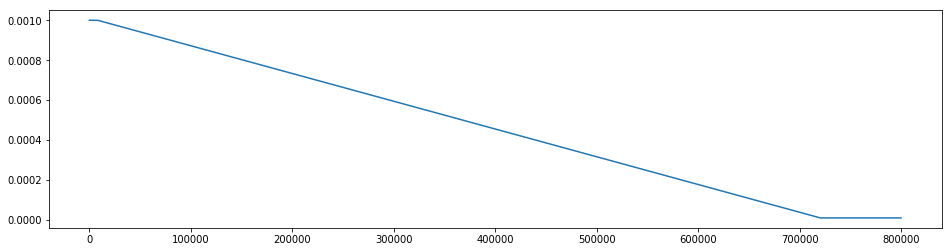

In [42]:
all_steps = []
all_lr = []

step = 0
for epoch in range(EPOCHS):
    for _ in range(steps_per_epoch_train):
        all_steps.append(step)
        all_lr.append(get_learning_rate(step, epoch, steps_per_epoch_train))
        step += 1 

plt.figure(figsize=(16,4))
plt.plot(all_steps, all_lr)

In [ ]:
# from math import ceil

# steps_per_epoch_train = int(ceil(EPOCHS/mb_size))
# def fit_bn_statistics():
#     sess.run(reset_bn_ops)
    
#     feed_dict = {is_training_bn: True, use_moving_statistics: True}
#     for _ in range(steps_per_epoch_train):
#         sess.run(update_bn_ops, feed_dict=feed_dict)

# def inference(with_moving_statistics=True):
#     feed_dict = {is_training_bn: False,
#                  use_moving_statistics: with_moving_statistics}
#     g_loss = []
#     d_loss = []
#     nb_steps = 10
    
#     for _ in range(nb_steps):
#         _, Dloss = sess.run([D_solver, D_loss], feed_dict=feed_dict_train)
#         _, Gloss = sess.run([G_solver, G_loss], feed_dict=feed_dict_train)
#         g_loss.append(Gloss)
#         d_loss.append(Dloss)
    
#     return np.mean(g_loss), np.mean(d_loss)

# feed_dict_train = {is_training_bn: True, 
#                    use_moving_statistics:True,}

feed_dict_train = {}

KS Plot


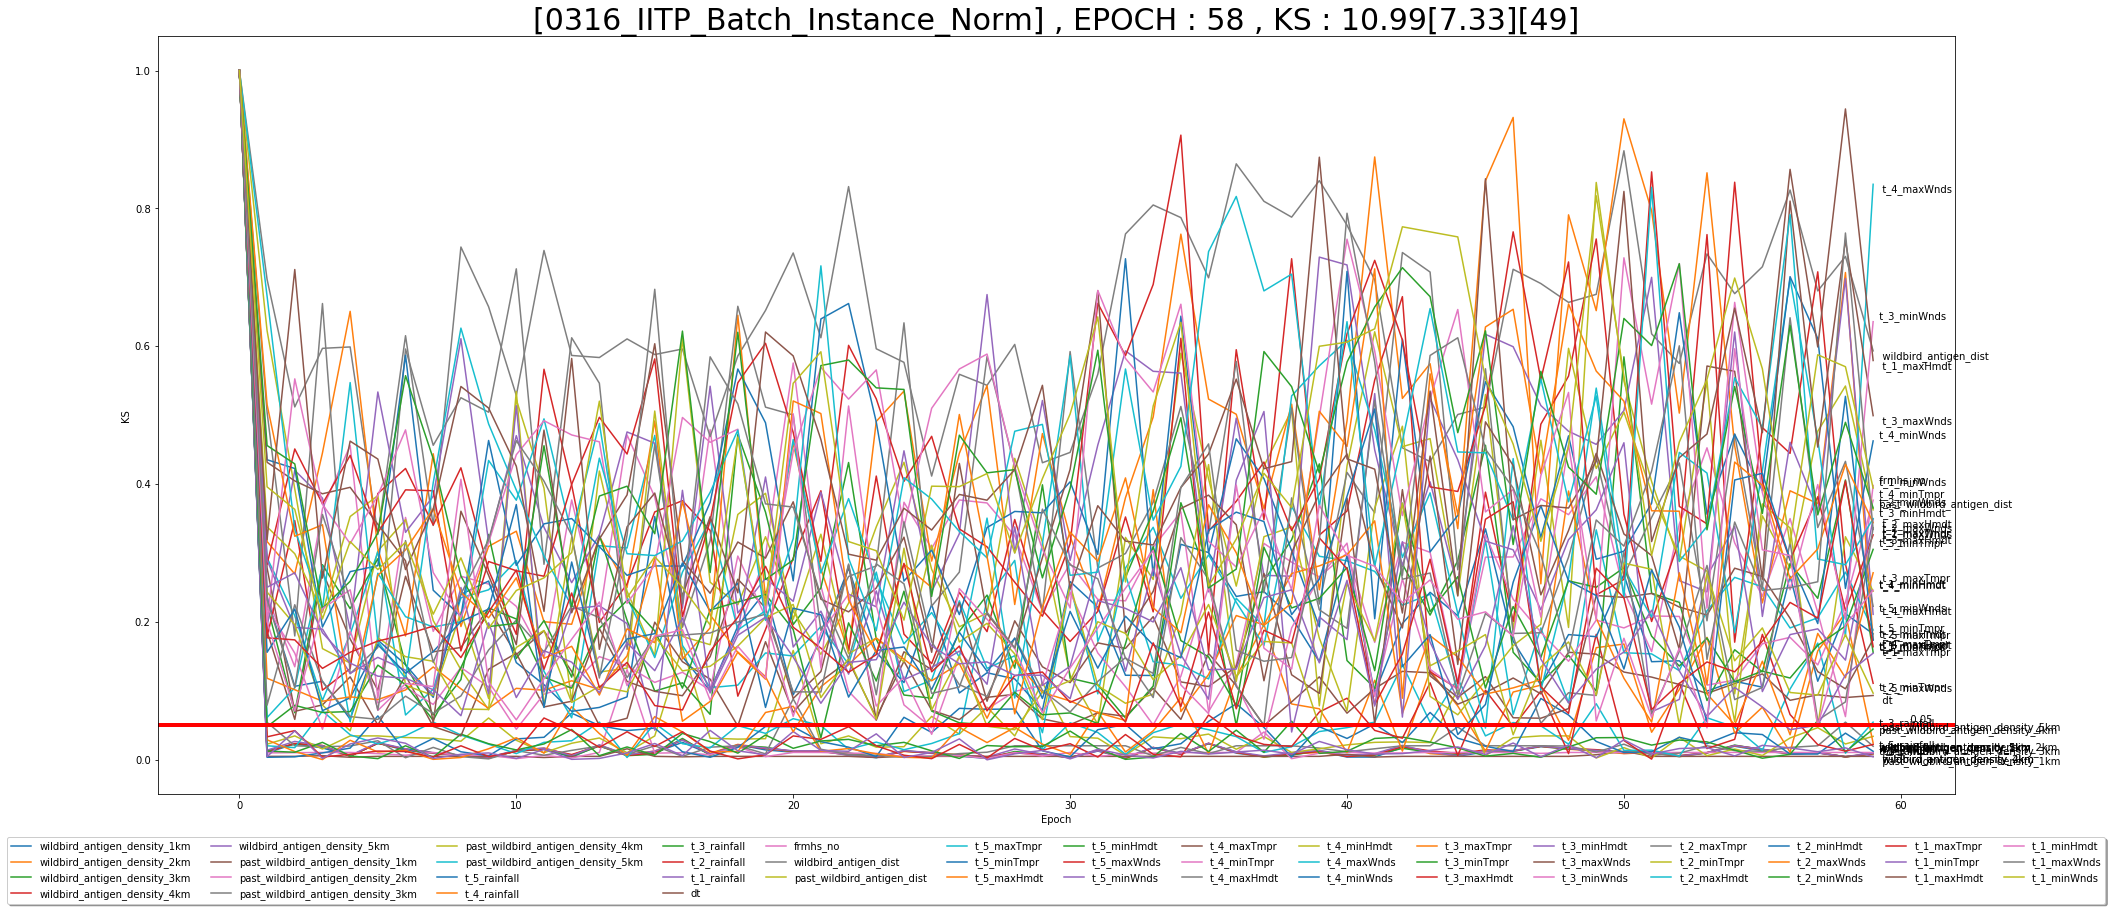

Total KS Plot


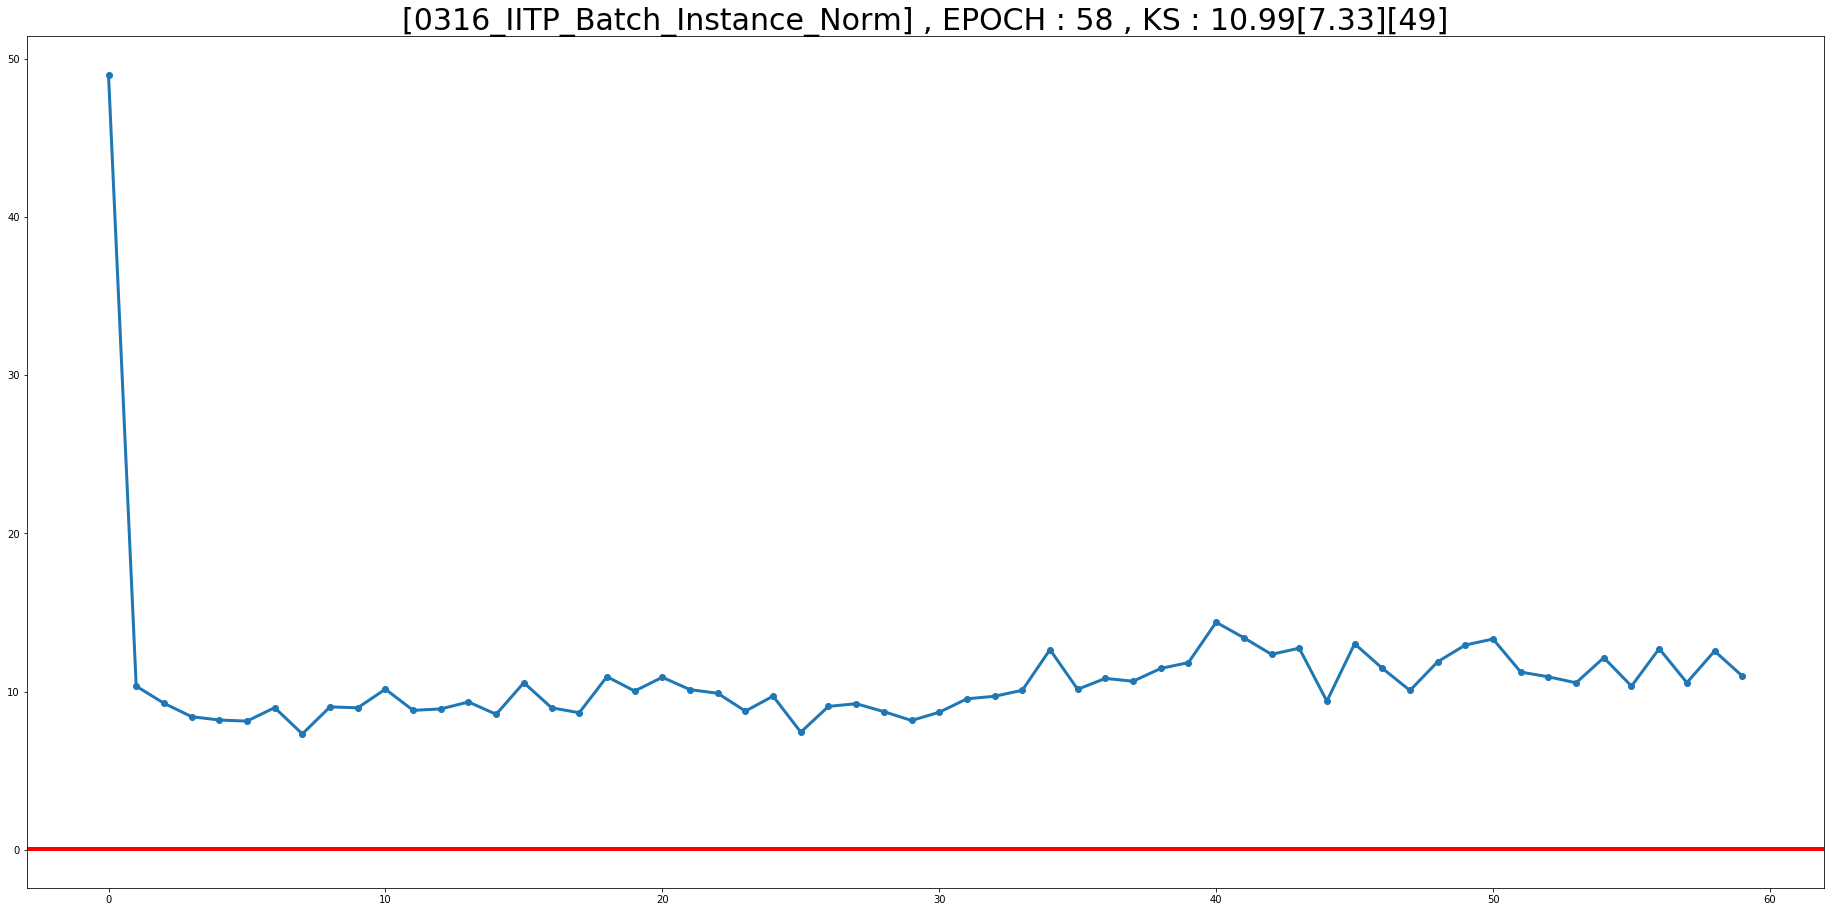

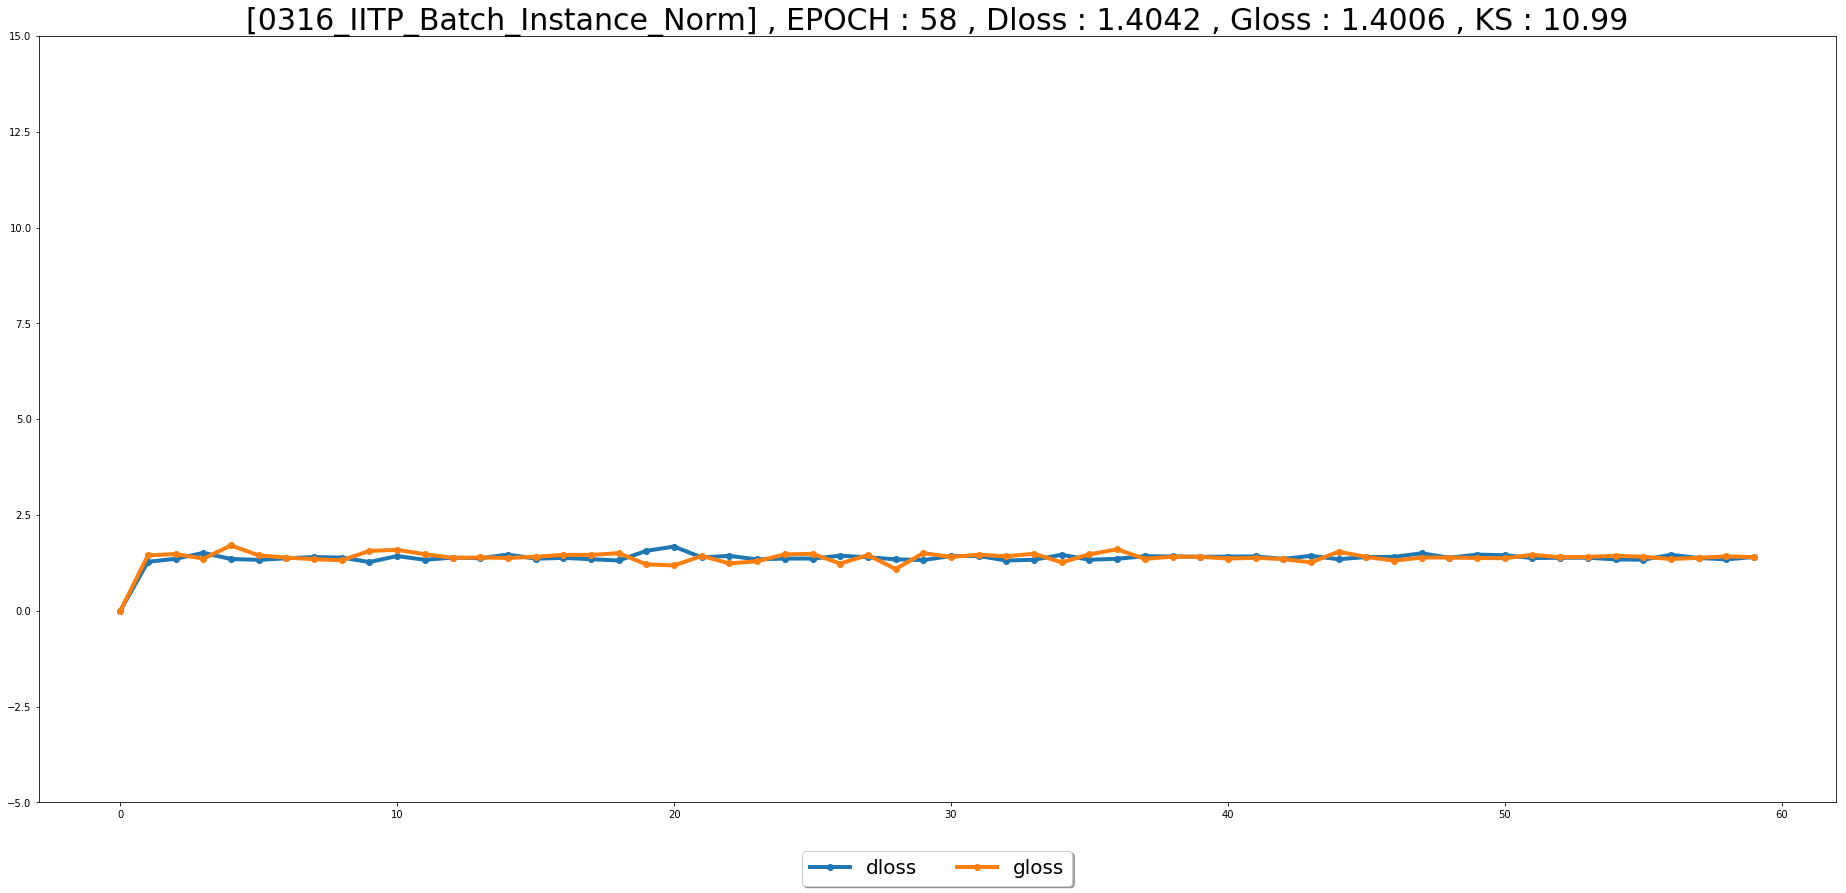

EPOCH : 58; D_loss: 1.4042; G_loss: 1.4006 , KS : 10.99
Recon Loss : 0.0


In [ ]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

print("START")
config=tf.ConfigProto( log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()


ks_output = pd.DataFrame([[0]+[1.]*len(col)], columns = ["iter"]+col)

iteration , dloss ,  gloss = 0 , 0, 0
output = pd.DataFrame({"iter" : [iteration] , "dloss" : [dloss] , "gloss" : [gloss] })
ks_init = len(col)
Total_ks_graph = pd.DataFrame({"iter":[iteration] , "ks" :[ks_init]})


step = 0

for i in range(EPOCHS) : 
    z_batch = sample_z(data_len , z_dim )
    sess.run(iter.initializer, feed_dict={ X : data , Z : z_batch  , batch_size: mb_size})
    iteration +=1
    for _ in range( batch_iter)  :
        feed_dict_train[learning_rate] = get_learning_rate(step, i , steps_per_epoch_train)
        step += 1 
        feed_dict_train[batch_size] = mb_size
        dloss = []
        for _ in range(d_steps) :
            _, Dloss = sess.run([D_solver, D_loss], feed_dict=feed_dict_train)
            dloss.append(Dloss)
        for _ in range(g_steps) : 
            _, gloss = sess.run([G_solver, G_loss], feed_dict=feed_dict_train)
            _, recon = sess.run([Recon_solver , recon_loss], feed_dict=feed_dict_train)
        dloss = np.mean(dloss)
        gloss = np.mean(gloss)
    
    
#     sess.run(swa_op)
#     sess.run(save_weight_backups)
#     sess.run(swa_to_weights)
#     sess.run(restore_weight_backups)
    
#     fit_bn_statistics()
#     dloss, gloss = inference(with_moving_statistics=False)
    
    output1 = pd.DataFrame({"iter" : [iteration] , "dloss" : [dloss] , "gloss" : [gloss] })
    output  = output.append(output1)
    dloss = round( np.float64(dloss),4)
    gloss = round( np.float64(gloss),4)
    ks_output , Total_ks_graph , Margin  , Total_KS = Check_KS(ks_output , Total_ks_graph , Margin , ROW , COL)
    print('EPOCH : {}; D_loss: {}; G_loss: {} , KS : {}'.format(i, dloss, gloss , Total_KS))
    print("Recon Loss : {}".format(recon))
    
    if (i % 10 == 0) &  (Margin < Margin_LIMIT ) :
        clear_output(wait= True)
        show_plot(row = ROW , ncol= COL)

